# Bradley-Terry Modeling of NBA Teams

This notebook processes the [`arena-human-preference-140k`](https://huggingface.co/datasets/lmarena-ai/arena-human-preference-140k) dataset to compute a leaderboard using a Contextual Bradley-Terry model, which controls for style elements in AI chat responses. This is the methodology used on the text leaderboard with style control. A full description is in our blog post: [Does style matter? Disentangling style and substance in Chatbot Arena](https://lmsys.org/blog/2024-08-28-style-control/).

We will:
1. Load the dataset.
2. Extract and normalize linguistic features (token count, bold usage, etc.).
3. Train the Contextual Bradley-Terry model using the `arena` package
4. Examine the style coefficients and plot the leaderboard and with confidence intervals.

In [11]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt

from arena.utils.data_utils import PairDataset
from arena.models.bradley_terry import BradleyTerry

### Style Feature Preprocessing
We use 4 style features, the counts of tokens, lists, headers, and bold elements. We preprocess the features to be relative differences rather than absolute differences, and normalize over the dataset.

In [ ]:
path = kagglehub.dataset_download("eoinamoore/historical-nba-data-and-player-box-scores")
df = pd.read_csv(f"{path}/Games.csv", low_memory=False)


def get_team_id_to_name_mapping(df):
    # map team_id to most recent team_name from home/away columns
    home = df[["gameDateTimeEst", "hometeamId", "hometeamName"]].rename(
        columns={"hometeamId": "team_id", "hometeamName": "team_name"}
    )
    away = df[["gameDateTimeEst", "awayteamId", "awayteamName"]].rename(
        columns={"awayteamId": "team_id", "awayteamName": "team_name"}
    )
    all_teams = pd.concat([home, away]).sort_values("gameDateTimeEst").drop_duplicates(subset="team_id", keep="last")
    return dict(zip(all_teams["team_id"], all_teams["team_name"]))


id_to_name = get_team_id_to_name_mapping(df)

df["home"] = df["hometeamId"].map(id_to_name)
df["away"] = df["awayteamId"].map(id_to_name)
df["winner"] = df.apply(lambda row: "home" if row["winner"] == row["hometeamId"] else "away", axis=1)
df = df[["gameDateTimeEst", "home", "away", "winner"]]


# df = df[df['gameDateTimeEst'].str[:10] >= (pd.Timestamp.now() - pd.DateOffset(years=10)).strftime('%Y-%m-%d')]
df

,gameDateTimeEst,home,away,winner
0,2025-12-01 17:00:00,Lakers,Suns,away
1,2025-12-01 16:00:00,Jazz,Rockets,home
2,2025-12-01 16:00:00,Nuggets,Mavericks,away
3,2025-12-01 14:30:00,Magic,Bulls,home
4,2025-12-01 14:30:00,Heat,Clippers,home
...,...,...,...,...
72253,1946-12-08 19:00:00,Knicks,Celtics,home
72254,1946-12-07 19:00:00,Celtics,Knicks,away
72255,1946-12-05 19:00:00,Warriors,Knicks,home
72256,1946-11-30 19:00:00,Knicks,Warriors,home


### Modeling
To use the `arena` package, we first instantiate a `ContextualPairDataset` object from out dataframe, this performs preprocessing and puts the data into a format useful for model fitting.

Second we create an instance of the `ContextualBradleyTerry` model class with the desired settings.

Finally we "train" the model, finding the ratings and feature coefficients via maximum likelihood estimation, and the confidence intervals using a [sandwich estimator](https://www.stat.umn.edu/geyer/5601/notes/sand.pdf).

In [ ]:
dataset = PairDataset.from_pandas(
    df,
    competitor_cols=["home", "away"],
    outcome_col="winner",
    outcome_map={"home": 1.0, "away": 0.0},
    reweighted=False,
)

model = BradleyTerry(n_competitors=dataset.n_competitors, init_rating=1200, tol=1e-12)

# compute ratings and 95% confidence intervals
results = model.compute_ratings_and_cis(dataset, significance_level=0.05)
competitors = dataset.competitors

L-BFGS finished in 45 iterations.
  Final Loss: 0.684324
  Rel F Diff: 2.21e-13 (tol=1e-12)
  Grad Norm:  4.48e-08 (tol=1e-12)


### Leaderboard Visualization
We can plot the ratings and confidence intervals and recover a leaderboard representing the style-controlled strengths as of July 2025 when this public dataset was released.

In [40]:
def plot_results(results, competitors, title, top_n=20):
    leaderboard_df = pd.DataFrame(
        {
            "Team": competitors,
            "Rating": results["ratings"],
            "Lower": results["rating_lower"],
            "Upper": results["rating_upper"],
        }
    )
    leaderboard_df = leaderboard_df.sort_values(by="Rating", ascending=False).reset_index(drop=True)

    # calculate error bar sizes
    leaderboard_df["error_lower"] = leaderboard_df["Rating"] - leaderboard_df["Lower"]
    leaderboard_df["error_upper"] = leaderboard_df["Upper"] - leaderboard_df["Rating"]

    plot_df = leaderboard_df.head(top_n)
    plt.figure(figsize=(14, 8))
    plt.errorbar(
        x=plot_df["Team"],
        y=plot_df["Rating"],
        yerr=[plot_df["error_lower"], plot_df["error_upper"]],
        fmt="o",
        color="royalblue",
        ecolor="gray",
        capsize=3,
        markersize=6,
    )
    plt.title(title, fontsize=16)
    plt.ylabel("Arena Score", fontsize=12)
    plt.xlabel("Model Name", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.tight_layout()
    plt.show()

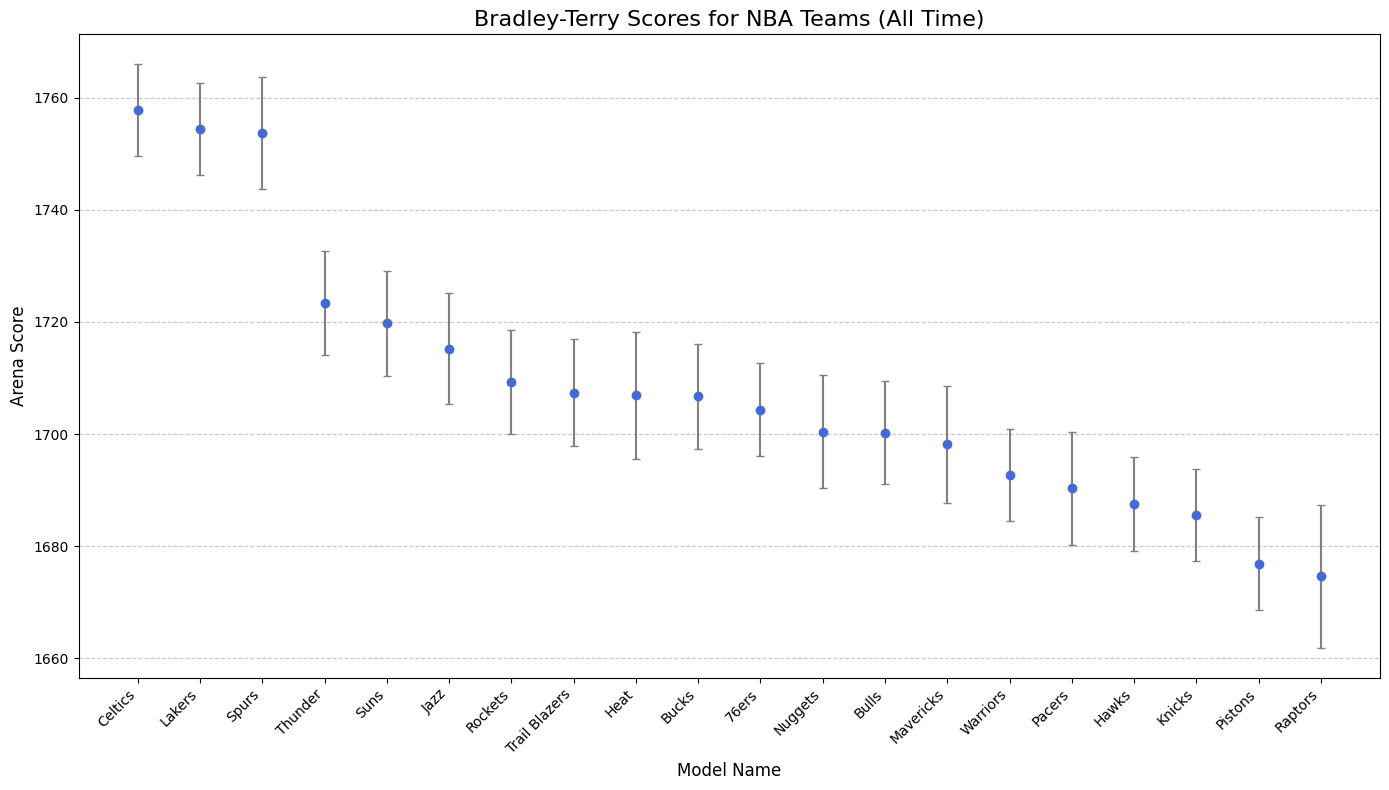

In [41]:
plot_results(results, competitors, title="Bradley-Terry Scores for NBA Teams (All Time)", top_n=20)

L-BFGS finished in 14 iterations.
  Final Loss: 0.511230
  Rel F Diff: 3.53e-13 (tol=1e-12)
  Grad Norm:  1.02e-08 (tol=1e-12)


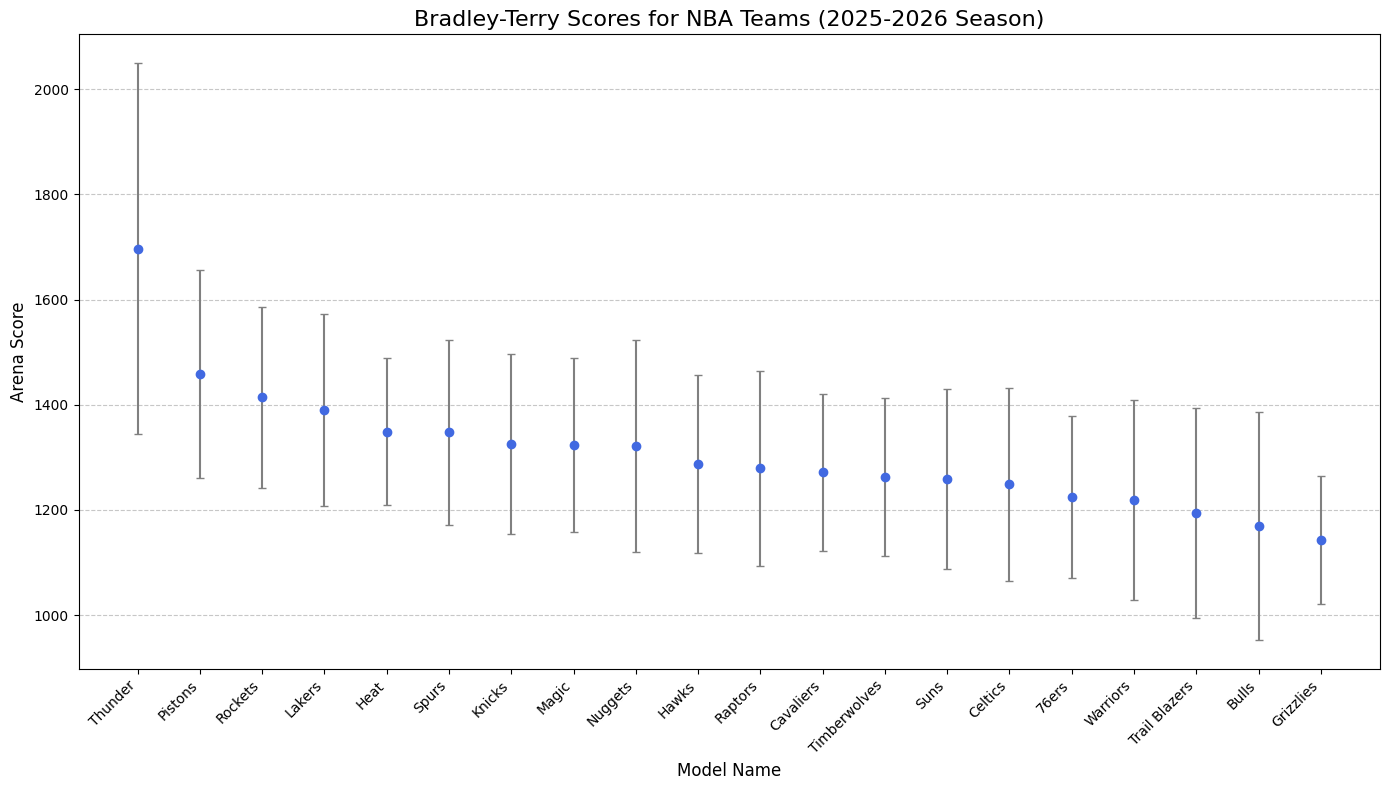

In [58]:
# look at just the last season
recent_df = df[(df["gameDateTimeEst"].str[:10] >= "2025-10-20") & (df["gameDateTimeEst"].str[:10] <= "2026-10-01")]
recent_dataset = PairDataset.from_pandas(
    recent_df,
    competitor_cols=["home", "away"],
    outcome_col="winner",
    outcome_map={"home": 1.0, "away": 0.0},
    reweighted=False,
)
recent_model = BradleyTerry(n_competitors=recent_dataset.n_competitors, init_rating=1200, tol=1e-12, hessian_reg=1e-5)
recent_results = recent_model.compute_ratings_and_cis(recent_dataset, significance_level=0.05)
recent_competitors = recent_dataset.competitors
plot_results(
    recent_results, recent_competitors, title="Bradley-Terry Scores for NBA Teams (2025-2026 Season)", top_n=20
)